# How to select targets for the CI cameras

## Guide for the impatient

Everything below basically boils down to the following code.  You need a targets table with columns `RA` and `DEC`,
a file defining the corners of the cameras (`ci.ecsv`), and `targets_on_gfa()` will return the subset
of rows that are covered by a camera, plus an additional column `GFA_LOC` indentifying which camera covered each
target.  Although that has `GFA` in the name, that is just because the code was originally written for GFAs; there
is nothing that is actually GFA-specific here.

In [1]:
import fitsio
from astropy.table import Table
import desimodel.focalplane

#- Load a targets file that has columns RA, DEC
targets = fitsio.read('gfas-dr7.1-0.27.0-lite.fits')

#- Load the CI camera location definitions
ci_cameras = Table.read('ci.ecsv')
ci = desimodel.focalplane.gfa.GFALocations(ci_cameras)

#- Use those to identify the subset of targets covered by the cameras
citargets = ci.targets_on_gfa(telra=0.0, teldec=0.0, targets=targets)

print('{}/{} targets on CI cameras'.format(len(citargets), len(targets)))
print('Output column names:', citargets.colnames)
print('GFA_LOC = CI Camera number = ', set(citargets['GFA_LOC']))

33/13451 targets on CI cameras
Output column names: ['TARGETID', 'BRICKID', 'BRICK_OBJID', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 'MORPHTYPE', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'REF_ID', 'PMRA', 'PMDEC', 'PMRA_IVAR', 'PMDEC_IVAR', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR', 'GAIA_ASTROMETRIC_EXCESS_NOISE', 'HPXPIXEL', 'GFA_LOC']
GFA_LOC = CI Camera number =  {1, 2, 3, 4, 5}


## More complete explanations below...

In [2]:
%pylab inline
import numpy as np
from astropy.table import Table
import desimodel.focalplane
import desimodel.io

Populating the interactive namespace from numpy and matplotlib


## Load the CI camera definition file

This file (`ci.ecsv`) will be added to `$DESIMODEL/data/focalplane/` after it is vetted.  It defines the corners of the CI cameras in focal plan coordinates.  The `GFA_LOC` column is the CI camera number 1-5; for full DESI it will be the GFA/petal location 0-9.  This is just an arbitrary integer for bookkeeping.  The format just specifies the locations of corners of cameras without constraints on whether they are CI or GFA or anything else.

In [3]:
ci_cameras = Table.read('ci.ecsv')
ci_cameras

<Table length=20>
GFA_LOC CORNER    X        Y     ...       Q             S          RADIUS_DEG  
 int64  int64  float64  float64  ...    float64       float64        float64    
------- ------ -------- -------- ... ------------- ------------- ---------------
      1      0 -407.766   13.824 ... 178.058313789 408.585575734   1.60764467106
      1      1 -407.766  -13.824 ... 181.941686211 408.585575734   1.60764467106
      1      2 -389.334  -13.824 ... 182.033534832 390.081516682   1.54054799237
      1      3 -389.334   13.824 ... 177.966465168 390.081516682   1.54054799237
      2      0   13.824  407.766 ... 88.0583137886 408.585575734   1.60764467106
      2      1  -13.824  407.766 ... 91.9416862114 408.585575734   1.60764467106
      2      2  -13.824  389.334 ... 92.0335348323 390.081516682   1.54054799237
      2      3   13.824  389.334 ... 87.9664651677 390.081516682   1.54054799237
      3      0   13.824    9.216 ...  33.690067526 16.6143818705 0.0683595477254
      3      1  -13.824    9.216 ... 146.309932474 16.6143818705 0.0683595477254
      3      2  -13.824   -9.216 ... 213.690067526 16.6143818705 0.0683595477254
      3      3   13.824   -9.216 ... 326.309932474 16.6143818705 0.0683595477254
      4      0  -13.824 -407.766 ... 268.058313789 408.585575734   1.60764467106
      4      1   13.824 -407.766 ... 271.941686211 408.585575734   1.60764467106
      4      2   13.824 -389.334 ... 272.033534832 390.081516682   1.54054799237
      4      3  -13.824 -389.334 ... 267.966465168 390.081516682   1.54054799237
      5      0  407.766  -13.824 ... 358.058313789 408.585575734   1.60764467106
      5      1  407.766   13.824 ... 1.94168621143 408.585575734   1.60764467106
      5      2  389.334   13.824 ...  2.0335348323 390.081516682   1.54054799237
      5      3  389.334  -13.824 ... 357.966465168 390.081516682   1.54054799237

## Toy Example: fake targets

This example shows the minimal inputs needed to identify which targets are on the CI cameras.  Basically it just takes
an input target table with columns `RA` and `DEC`, and returns the subset of rows that are covered by any camera, plus a
new `GFA_LOC` column indicating which camera covers each target.

In [4]:
#- Generate a random set of RA,dec around RA,dec=0,0
n = 20000
ra = np.random.uniform(-2, 2, size=n)
dec = np.random.uniform(-2, 2, size=n)
targets = Table(dict(RA=ra, DEC=dec))

#- Get the subset of those targets that are covered by a camera
ci = desimodel.focalplane.gfa.GFALocations(ci_cameras)
citargets = ci.targets_on_gfa(telra=0.0, teldec=0.0, targets=targets)

The output table is a subset of the rows of the input table, with a new column `GFA_LOC` given the CI camera number (1-5)

In [5]:
print('{}/{} targets on CI cameras'.format(len(citargets), len(targets)))
print('Output column names:', citargets.colnames)
print('GFA_LOC = CI Camera number = ', set(citargets['GFA_LOC']))

45/20000 targets on CI cameras
Output column names: ['RA', 'DEC', 'GFA_LOC']
GFA_LOC = CI Camera number =  {1, 2, 3, 4, 5}


### Visualize

The following code plots negative RAs for convenience, but note that the original "is this target covered by a CI camera" code used 0 <= RA < 360 and handled the RA wraparound correctly.

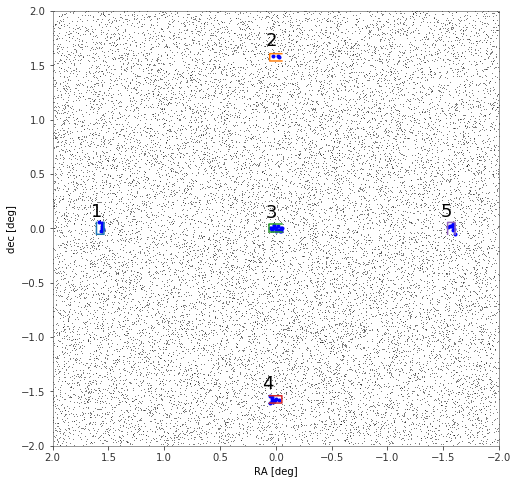

In [6]:
def wrap_ra(ra):
    '''return (-180, 180) instead of (0,360)'''
    return (ra+180)%360 - 180

def plot_gfa_targets(targets, citargets):
    figure(figsize=(8,8))
    
    plot(wrap_ra(targets['RA']), targets['DEC'], 'k,', alpha=0.5)
    plot(wrap_ra(citargets['RA']), citargets['DEC'], 'b.')
    for cam in [1,2,3,4,5]:
        ii = citargets['GFA_LOC'] == cam
        x = np.mean(wrap_ra(citargets['RA'][ii]))
        y = np.mean(wrap_ra(citargets['DEC'][ii]))
        text(x+0.1, y+0.1, str(cam), fontsize=18)

    xlim(2, -2); ylim(-2, 2)
    xlabel('RA [deg]'); ylabel('dec [deg]')

def draw_cameras(telra, teldec, cameras):
    for cam in sorted(set(cameras['GFA_LOC'])):
        ii = cameras['GFA_LOC'] == cam
        xx = cameras['X'][ii]
        yy = cameras['Y'][ii]
    
        ra, dec = desimodel.focalplane.xy2radec(telra, teldec, xx, yy)
        ra = wrap_ra(ra)
        plot(ra, dec)

plot_gfa_targets(targets, citargets)
draw_cameras(0, 0, ci_cameras)

## Real example: actual Gaia targets

Uses `/project/projectdirs/desi/target/catalogs/dr7.1/0.27.0/gfas-dr7.1-0.27.0.fits`

For my laptop testing I actually trimmed this with
```
import fitsio
data, header = fitsio.read('/project/projectdirs/desi/target/catalogs/dr7.1/0.27.0/gfas-dr7.1-0.27.0.fits', header=True)
ii = (data['RA']>358) | (data['RA'] < 2)
ii &= (-2 < data['DEC']) & (data['DEC'] < 2)
fitsio.write('gfas-dr7.1-0.27.0-lite.fits', data[ii], header=header, overwrite=True)
```

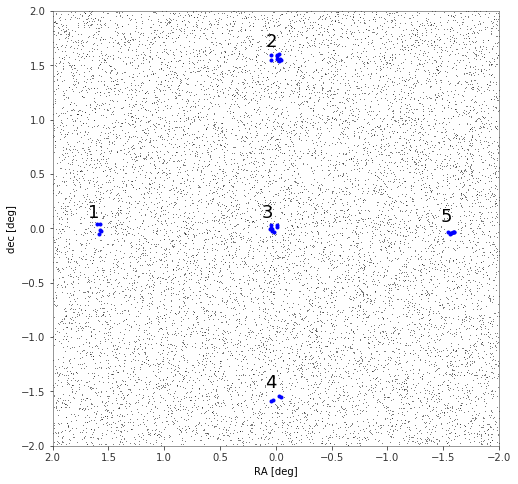

In [7]:
targets = Table.read('gfas-dr7.1-0.27.0-lite.fits')  #- Or fitsio.read
citargets = ci.targets_on_gfa(telra=0.0, teldec=0.0, targets=targets)
plot_gfa_targets(targets, citargets)

In [8]:
citargets

<Table length=33>
     TARGETID     BRICKID BRICK_OBJID ... HPXPIXEL GFA_LOC
      int64        int32     int32    ...  int64    int16 
----------------- ------- ----------- ... -------- -------
30787681038370196  323167        1428 ...    17404       4
30787717251991364  331801        1860 ...    18774       5
30787717251991737  331801        2233 ...    18774       5
30787717251991755  331801        2251 ...    18774       5
30787717251991756  331801        2252 ...    18774       5
30787717251991757  331801        2253 ...    18774       5
30787717251991664  331801        2160 ...    18774       5
30787717251991682  331801        2178 ...    18774       5
30787681038370414  323167        1646 ...    17404       4
30787675002766118  321728         806 ...    17404       4
              ...     ...         ... ...      ...     ...
30787753515946273  340447        4385 ...    19459       2
30787753515946788  340447        4900 ...    19459       2
30787753515947925  340447        6037 ...    19459       2
30787753515946533  340447        4645 ...    19459       2
30787747480343126  339008        4694 ...    19459       2
30787753515946853  340447        4965 ...    19459       2
30787753515947411  340447        5523 ...    19459       2
30787747480344608  339008        6176 ...    19459       2
30787753515947770  340447        5882 ...    19459       2
30787711266721796  330374        4100 ...    18089       1

### Output the CI targets file

Note: for full DESI, ICS / Platemaker expect the extension to be called `GFA_TARGETS`.  I'm not sure how this is handled for the commissioning instrument.  Also `GFA_TARGETS`, or something else like `CI_TARGETS`?

In [9]:
citargets.meta['EXTNAME'] = 'GFA_TARGETS'
citargets.write('ci-targets.fits', overwrite=True)

## What's next?

After vetting that the `ci.ecsv` file is correct and the code is correctly assigning the right targets to the right cameras and that `gfas-dr7.1-0.27.0.fits` contains a useful set of columns, we can wrap this to generate CI targets for N>>1 locations on the sky.